### FastSpecFit Nebular Lines

Develop the set of nebular emission lines that *fastspecfit* should model.

References:
 * https://www.pa.uky.edu/~peter/newpage/instruction.html#transitions
 * https://github.com/Morisset/PyNeb_devel/tree/master/examples

In [1]:
import pdb
import numpy as np
import pyneb as pn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(context='talk', style='ticks', palette='deep', font_scale=1.1)
colors = sns.color_palette()

%matplotlib inline

### Update the PyNeb atomic data

In [2]:
#print(O3.atomPath, O3.collPath)
#pn.atomicData.getAllAvailableFiles('O2')


In [3]:
pn.atomicData.addDataFilePath('data')
DataFileDict = {
    'O2':  {'atom': 'o_ii_atom_FFT04.dat',   'coll': 'o_ii_coll_Kal09.dat'},
    'O3':  {'atom': 'o_iii_atom_FFT04.dat',  'coll': 'o_iii_coll_SSB14.dat'},  
    'N2':  {'atom': 'n_ii_atom_FFT04.dat',   'coll': 'n_ii_coll_T11.dat'},
    'Ne3': {'atom': 'ne_iii_atom_FFT04.dat', 'coll': 'ne_iii_coll_McLB00.dat'},
    'Ar3': {'atom': 'ar_iii_atom_MZ83.dat',  'coll': 'ar_iii_coll_MB09.dat'},
    'S2':  {'atom': 's_ii_atom_IFF05.dat',   'coll': 's_ii_coll_TZ10.dat'},
    'S3':  {'atom': 's_iii_atom_FFTI06.dat', 'coll': 's_iii_coll_HRS12.dat'},
    'Cl3': {'atom': 'cl_iii_atom_RGJ19.dat', 'coll': 'cl_iii_coll_BZ89.dat'}
}
pn.atomicData.setDataFileDict(DataFileDict)

In [4]:
def air2vac(airwave):
    """http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion"""
    if airwave <= 0:
        raise ValueError('Input wavelength is not defined.')
    ss = 1e4 / airwave
    nn = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - ss**2) + 0.0001599740894897 / (38.92568793293 - ss**2)
    return airwave * nn

In [5]:
def atominfo(atom='Ne', ion=3, temp=1e4, dens=1e2):
    atm = pn.Atom(atom, ion)
    nlevel = atm.NLevels
    emis = atm.getEmissivity(temp, dens)
    for i in range(1, nlevel):
        for j in range(i):
            airwave = atm.wave_Ang[i, j]
            vacwave = air2vac(airwave)
            if airwave < 1.5e4 and emis[i, j] > 1e-25:
                print('[{}{}] ({}-->{}): airwave: {:.4f} vacwave: {:.4f} emissivity: {:.5e}'.format(
                    atom, ion, i+1, j+1, airwave, vacwave, emis[i, j]))

### Density and temperature dependence of the [OII] 3726,29, [SII] 6716,31, and [OII] 7320,30 doublets.

In [6]:
def get_doublet_ratio(atom, ion, dens, temp, iweak, istrong, label):
    ratio = np.zeros((ntemp, ndens))

    atm = pn.Atom(atom, ion)
    for jj in np.arange(ntemp):
        for ii in np.arange(ndens):
            emis = atm.getEmissivity(temp[jj], dens[ii])
            # [OII] 3726/3729, [OII] 7330/7320, or [SII] 6730/6716
            ratio[jj, ii] = emis[iweak[0], iweak[1]] / emis[istrong[0], istrong[1]] 
        print('{} = {:.5f} at n = {:.0f} / cm3, T = {:.0f} K'.format(label, ratio[jj, 0], dens[0], temp[jj]))
        print('{} = {:.5f} at n = {:.0f} / cm3, T = {:.0f} K'.format(
            label, np.interp(dens_nominal, dens, ratio[jj, :]), dens_nominal, temp[jj]))
        print('{} = {:.5f} at n = {:.0f} / cm3, T = {:.0f} K'.format(
            label, ratio[jj, -1], dens[-1], temp[jj]))
        print()
        
    ls = ['-', '--', '-.']
    fig, ax = plt.subplots(figsize=(8, 6))
    for jj in np.arange(ntemp):
        ax.plot(dens, ratio[jj, :], ls=ls[jj], 
                label='T = {:.0f} K'.format(temp[jj]))
    ax.margins(x=0, y=0.2)
    ax.axvline(x=100, ls='-', lw=2, color='k')
    ax.set_xlabel(r'Electron Density (cm$^{-3}$)')
    ax.set_ylabel(r'{}'.format(label))
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.legend(loc='upper left');

In [7]:
atominfo(atom='O', ion=1, temp=1e4, dens=1e2)

[O1] (4-->1): airwave: 6300.3010 vacwave: 6302.0435 emissivity: 6.51241e-22
[O1] (4-->2): airwave: 6363.7733 vacwave: 6365.5328 emissivity: 2.07993e-22
[O1] (5-->2): airwave: 2972.2861 vacwave: 2973.1539 emissivity: 1.60157e-24
[O1] (5-->4): airwave: 5577.3367 vacwave: 5578.8855 emissivity: 1.42631e-23


In [8]:
atominfo(atom='O', ion=2, temp=1e4, dens=1e2)

[O2] (2-->1): airwave: 3728.8145 vacwave: 3729.8750 emissivity: 1.95864e-21
[O2] (3-->1): airwave: 3726.0322 vacwave: 3727.0919 emissivity: 1.43734e-21
[O2] (4-->1): airwave: 2470.3405 vacwave: 2471.0873 emissivity: 3.63811e-23
[O2] (4-->2): airwave: 7319.9849 vacwave: 7322.0018 emissivity: 2.40519e-23
[O2] (4-->3): airwave: 7330.7308 vacwave: 7332.7506 emissivity: 1.27488e-23
[O2] (5-->1): airwave: 2470.2190 vacwave: 2470.9658 emissivity: 9.42698e-24
[O2] (5-->2): airwave: 7318.9185 vacwave: 7320.9350 emissivity: 8.18137e-24
[O2] (5-->3): airwave: 7329.6613 vacwave: 7331.6807 emissivity: 1.35614e-23


In [9]:
print('[OII] 7320 wave = {:.4f} A'.format(np.sum(2.40519e-23*7322.0018 + 8.18137e-24*7320.9350) / np.sum([2.40519e-23, 8.18137e-24])))
print('[OII] 7330 wave = {:.4f} A'.format(np.sum(1.35614e-23*7331.6807 + 1.27488e-23*7332.7506) / np.sum([1.35614e-23, 1.27488e-23])))
print('[OII] 7330 / 7320 ratio: {:.4f}'.format((np.array([8.18137e-24+2.40519e-23])/np.array([1.35614e-23+1.27488e-23]))[0]))

[OII] 7320 wave = 7321.7310 A
[OII] 7330 wave = 7332.1991 A
[OII] 7330 / 7320 ratio: 1.2251


In [10]:
atominfo(atom='S', ion=2, temp=1e4, dens=1e2)

[S2] (2-->1): airwave: 6730.8124 vacwave: 6732.6705 emissivity: 2.12452e-20
[S2] (3-->1): airwave: 6716.4370 vacwave: 6718.2913 emissivity: 2.78381e-20
[S2] (4-->1): airwave: 4076.3490 vacwave: 4077.5000 emissivity: 6.29106e-22
[S2] (4-->2): airwave: 10336.4007 vacwave: 10339.2336 emissivity: 4.57638e-22
[S2] (4-->3): airwave: 10370.4869 vacwave: 10373.3291 emissivity: 2.18137e-22
[S2] (5-->1): airwave: 4068.5998 vacwave: 4069.7487 emissivity: 1.95883e-21
[S2] (5-->2): airwave: 10286.7212 vacwave: 10289.5407 emissivity: 4.63244e-22
[S2] (5-->3): airwave: 10320.4801 vacwave: 10323.3087 emissivity: 6.30251e-22
[S2] (6-->1): airwave: 1259.5190 vacwave: 1260.0680 emissivity: 9.56964e-24
[S2] (7-->1): airwave: 1253.8111 vacwave: 1254.3617 emissivity: 7.81218e-24
[S2] (8-->1): airwave: 1250.5845 vacwave: 1251.1361 emissivity: 3.53543e-24


In [11]:
atominfo(atom='O', ion=3, temp=1e4, dens=1e2)

[O3] (4-->1): airwave: 4931.2257 vacwave: 4932.6022 emissivity: 4.03115e-25
[O3] (4-->2): airwave: 4958.9097 vacwave: 4960.2937 emissivity: 1.20001e-21
[O3] (4-->3): airwave: 5006.8417 vacwave: 5008.2383 emissivity: 3.46929e-21
[O3] (5-->2): airwave: 2320.9501 vacwave: 2321.6631 emissivity: 5.73355e-24
[O3] (5-->4): airwave: 4363.2088 vacwave: 4364.4351 emissivity: 2.27902e-23


In [12]:
atominfo(atom='N', ion=2, temp=1e4, dens=1e2)

[N2] (4-->1): airwave: 6527.2282 vacwave: 6529.0316 emissivity: 1.08165e-24
[N2] (4-->2): airwave: 6548.0488 vacwave: 6549.8578 emissivity: 2.02198e-21
[N2] (4-->3): airwave: 6583.4511 vacwave: 6585.2696 emissivity: 5.94901e-21
[N2] (5-->2): airwave: 3062.8259 vacwave: 3063.7162 emissivity: 4.68205e-24
[N2] (5-->4): airwave: 5754.5925 vacwave: 5756.1887 emissivity: 8.88829e-23
[N2] (6-->2): airwave: 2139.0081 vacwave: 2139.6825 emissivity: 3.28518e-23
[N2] (6-->3): airwave: 2142.7727 vacwave: 2143.4478 emissivity: 8.05380e-23


In [13]:
atominfo(atom='S', ion=3, temp=1e4, dens=1e2)

[S3] (4-->1): airwave: 8829.3855 vacwave: 8831.8101 emissivity: 2.22545e-24
[S3] (4-->2): airwave: 9068.6140 vacwave: 9071.1034 emissivity: 7.63518e-21
[S3] (4-->3): airwave: 9530.6129 vacwave: 9533.2274 emissivity: 1.88499e-20
[S3] (5-->2): airwave: 3721.6295 vacwave: 3722.6880 emissivity: 2.76678e-22
[S3] (5-->3): airwave: 3797.1709 vacwave: 3798.2491 emissivity: 3.61839e-24
[S3] (5-->4): airwave: 6312.0606 vacwave: 6313.8062 emissivity: 5.13337e-22


In [14]:
atominfo(atom='Ne', ion=3, temp=1e4, dens=1e2)

[Ne3] (4-->1): airwave: 3868.7643 vacwave: 3869.8611 emissivity: 1.13459e-21
[Ne3] (4-->2): airwave: 3967.4708 vacwave: 3968.5933 emissivity: 3.42522e-22
[Ne3] (5-->2): airwave: 1814.5585 vacwave: 1815.1820 emissivity: 2.30422e-24
[Ne3] (5-->4): airwave: 3342.1813 vacwave: 3343.1423 emissivity: 1.54138e-24


In [15]:
atominfo(atom='Ne', ion=5, temp=1e4, dens=1e2)

[Ne5] (4-->2): airwave: 3345.8208 vacwave: 3346.7828 emissivity: 3.37738e-22
[Ne5] (4-->3): airwave: 3425.8813 vacwave: 3426.8637 emissivity: 9.21828e-22
[Ne5] (5-->2): airwave: 1574.6997 vacwave: 1575.0738 emissivity: 2.03461e-24
[Ne5] (5-->4): airwave: 2973.1337 vacwave: 2974.0017 emissivity: 7.64606e-25


In [16]:
dens_nominal = 100
temp_nominal = 1e4

temp = np.array([5000.0, 1e4, 2e4])
ntemp = len(temp)

ndens = 30
dens = np.logspace(0, 3, ndens)

In [17]:
#atm = pn.Atom('O', 2)
#emis = atm.getEmissivity(1e4, 100)
#emis[3, 2], emis[3, 1]
##emis.shape

[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.66288 at n = 1 / cm3, T = 5000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.75393 at n = 100 / cm3, T = 5000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 1.31008 at n = 1000 / cm3, T = 5000 K

[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.66707 at n = 1 / cm3, T = 10000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.73382 at n = 100 / cm3, T = 10000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 1.18342 at n = 1000 / cm3, T = 10000 K

[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.67511 at n = 1 / cm3, T = 20000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.72661 at n = 100 / cm3, T = 20000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 1.09726 at n = 1000 / cm3, T = 20000 K

-------------------------------------------------------
[S II] $\lambda6731$ / [S II] $\lambda6716$ = 0.68097 at n = 1 / cm3, T = 5000 K
[S II] $\lambda6731$ / [S II] $\lambda6716$ = 0.78097 at n = 100 / cm3, T = 5000 K
[S II] $\lambda6731$ / [S I

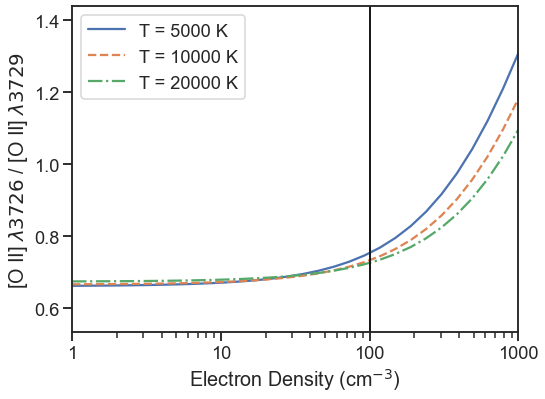

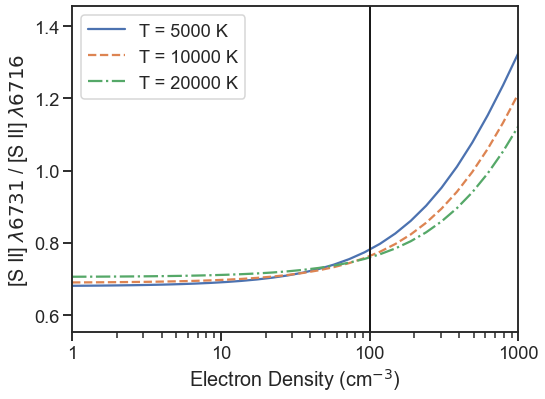

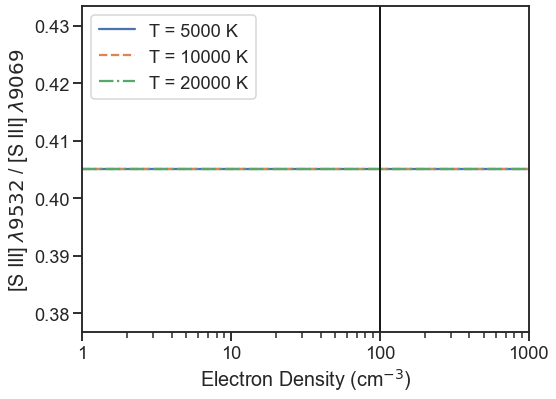

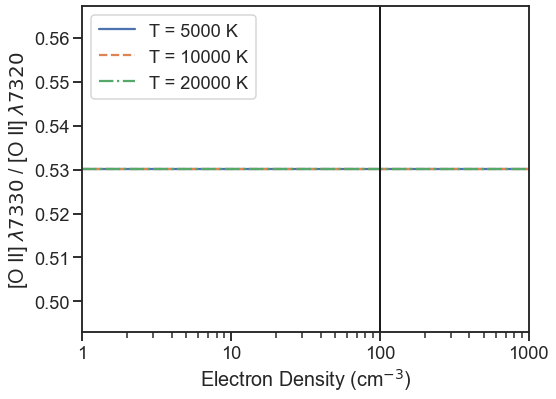

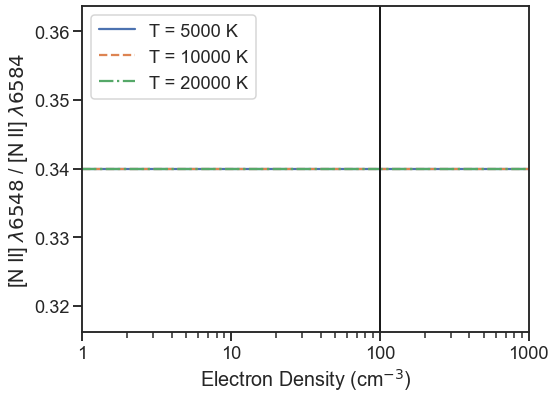

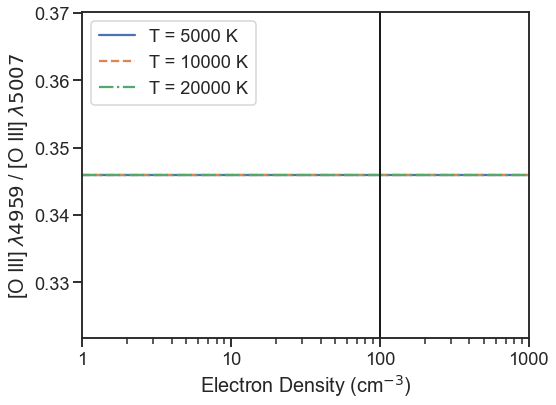

In [18]:
atoms = [
    'O', 
    'S', 
    'S', 
    'O',
    'N',
    'O',
]
ions = [
    2, 
    2, 
    3,
    2,
    2,
    3,
]
iweaks = [
    [2, 0], # [OII] 3726
    [1, 0], # [SII] 6731
    [3, 1], # [SIII] 9069
    [3, 2], # [OII] 7330
    [3, 1], # [NII] 6548
    [3, 1], # [OIII] 4959    
] 
istrongs = [
    [1, 0], # [OII] 3729
    [2, 0], # [SII] 6716
    [3, 2], # [SIII] 9532
    [3, 1], # [OII] 7320
    [3, 2], # [NII] 6584
    [3, 2], # [OIII] 5007
] 
labels = [
    '[O II] $\lambda3726$ / [O II] $\lambda3729$',
    '[S II] $\lambda6731$ / [S II] $\lambda6716$',
    '[S III] $\lambda9532$ / [S III] $\lambda9069$',
    '[O II] $\lambda7330$ / [O II] $\lambda7320$',
    '[N II] $\lambda6548$ / [N II] $\lambda6584$',
    '[O III] $\lambda4959$ / [O III] $\lambda5007$',
]

#print(iweaks[1], istrongs[1])
#get_doublet_ratio(atoms[1], ions[1], dens, temp, iweaks[1], istrongs[1])

for atom, ion, iweak, istrong, label in zip(atoms, ions, iweaks, istrongs, labels):
    get_doublet_ratio(atom, ion, dens, temp, iweak, istrong, label)
    print('-------------------------------------------------------')

### Building a complete line-list

In [19]:
allatoms = ('O', 'O', 'Ne', 'Ne', 'Ar', 'S')
allions = (2, 3, 3, 5, 3, 3)

In [20]:
for atom, ion in zip(allatoms, allions):
    atominfo(atom=atom, ion=ion)
    print()

[O2] (2-->1): airwave: 3728.8145 vacwave: 3729.8750 emissivity: 1.95864e-21
[O2] (3-->1): airwave: 3726.0322 vacwave: 3727.0919 emissivity: 1.43734e-21
[O2] (4-->1): airwave: 2470.3405 vacwave: 2471.0873 emissivity: 3.63811e-23
[O2] (4-->2): airwave: 7319.9849 vacwave: 7322.0018 emissivity: 2.40519e-23
[O2] (4-->3): airwave: 7330.7308 vacwave: 7332.7506 emissivity: 1.27488e-23
[O2] (5-->1): airwave: 2470.2190 vacwave: 2470.9658 emissivity: 9.42698e-24
[O2] (5-->2): airwave: 7318.9185 vacwave: 7320.9350 emissivity: 8.18137e-24
[O2] (5-->3): airwave: 7329.6613 vacwave: 7331.6807 emissivity: 1.35614e-23

[O3] (4-->1): airwave: 4931.2257 vacwave: 4932.6022 emissivity: 4.03115e-25
[O3] (4-->2): airwave: 4958.9097 vacwave: 4960.2937 emissivity: 1.20001e-21
[O3] (4-->3): airwave: 5006.8417 vacwave: 5008.2383 emissivity: 3.46929e-21
[O3] (5-->2): airwave: 2320.9501 vacwave: 2321.6631 emissivity: 5.73355e-24
[O3] (5-->4): airwave: 4363.2088 vacwave: 4364.4351 emissivity: 2.27902e-23

[Ne3] (4--

In [21]:
atm = pn.Atom('Ne', 3)
atm.printIonic(tem=1e4, den=1e2, printA=True)

elem = Ne
spec = 3
temperature = 10000.0 K
density =  100.0 cm-3

Level   Populations  Critical densities
Level 1:  9.995E-01  0.000E+00
Level 2:  2.587E-04  2.043E+05
Level 3:  2.832E-04  2.868E+04
Level 4:  1.254E-07  1.073E+07
Level 5:  1.019E-11  1.150E+08

5.845E-03   
     15.55m 
    (2-->1) 
  1.931E-21 

2.054E-08   1.101E-03   
     10.86m      36.00m 
    (3-->1)     (3-->2) 
  1.064E-26   1.720E-22 

1.762E-01   5.455E-02   0.000E+00   
   3868.76A    3967.47A    4011.68A 
    (4-->1)     (4-->2)     (4-->3) 
  1.135E-21   3.425E-22   0.000E+00 

4.163E-03   2.065E+00   0.000E+00   2.545E+00   
   1793.64A    1814.56A    1823.75A    3342.18A 
    (5-->1)     (5-->2)     (5-->3)     (5-->4) 
  4.699E-27   2.304E-24   0.000E+00   1.541E-24 

ERROR Atom H1: /Users/ioannis/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pyneb/atomic_data_fits//h_i_rec_SH95.hdf5 recombination file not read
